# Seq2Seq 기반 챗봇 만들기

> 3. 챗봇 모듈

In [ ]:
# 모듈 불러오기
from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pickle

import numpy as np
from IPython.display import SVG
from keras.utils import model_to_dot

In [ ]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"
chatbot_path = f"{root_path}/Seq2Seq-Chatbot"

In [ ]:
# 단어 목록
with open(f"{data_path}/6-1.vocabulary.pickle", 'rb') as f:
    word2idx, idx2word = pickle.load(f)

## 모델 구성

 학습 모델과 동일하게 구성한다. 모델을 컴파일하여 학습하지 않고, 이미 학습된 모델의 가중치를 가져 온다.

In [ ]:
# 모델 파라미터 설정
VOCAB_SIZE = len(idx2word)
EMB_SIZE = int(input('임베딩 출력 차원 설정: '))
LSTM_HIDDEN = int(input('LSTM 은닉 노드 수 설정: '))
MAX_LENGTH = int(input('문장 최대 길이 설정(주의): '))
MODEL_PATH = f"{chatbot_path}/Seq2Seq.h5"

임베딩 출력 차원 설정: 128
LSTM 은닉 노드 수 설정: 128
문장 최대 길이 설정(주의): 10


========== 모델 전체 구조 확인 ==========
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             2650240     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 10, 128), (N 

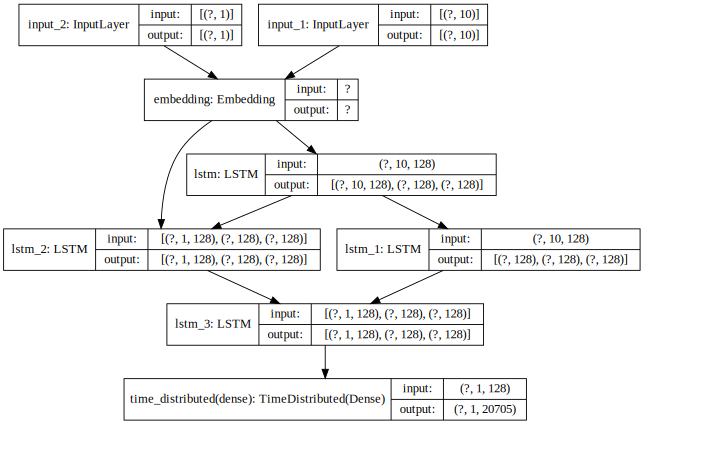

In [ ]:
# 세션 클리어
K.clear_session()

# 공통 임베딩 레이어
wordEmbedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)

# Encoder 네트워크 구성
X_input_E = Input(batch_shape=(None, MAX_LENGTH)) # 변경
X_embed_E = wordEmbedding(X_input_E)
X_lstm1_E = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
X_lstm2_E = LSTM(LSTM_HIDDEN, return_state=True)
ey1, eh1, ec1 = X_lstm1_E(X_embed_E)
_, eh2, ec2 = X_lstm2_E(ey1) # 1층의 출력을 받는다

# Decoder 네트워크 구성
X_input_D = Input(batch_shape=(None, 1)) # 변경: 단어 1개만 입력 받음.
X_embed_D = wordEmbedding(X_input_D)
X_lstm1_D = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
X_lstm2_D = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
dy1, _, _ = X_lstm1_D(X_embed_D, initial_state=[eh1, ec1]) # 초기 상태 설정
dy2, _, _ = X_lstm2_D(dy1, initial_state=[eh2, ec2]) # 초기 상태 설정

# 출력 네트워크
y_output = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax')) # 시간 분배
y_output = y_output(dy2)

# 모델 구성
model = Model([X_input_E, X_input_D], y_output)
model.load_weights(MODEL_PATH) # 변경: 학습 모듈에서의 가중치 로드
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

## Chatting용 모델
- 인코더에 입력하고, 인코더 모델에서의 h, c를 모두 출력한다.
- initial state를 입력받아서 설정한다.
- 디코더 모델에서는 초기 상태를 한 번씩 입력 받고 업데이트하기 위해, 번거롭지만 따로 구성하자.
- 출력은 그대로 넣어주기만 하면 된다.
- 디코더 모델은 다음과 같다.
    - 디코더 입력을 받는다.
    - 업데이트할 가중치도 입력 받는다.
    - 예측치 나오면(y_output) 그걸 다시 넣어서 가중치 업데이ㅡ.

========== 인코더 모델 구조 확인 ==========
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        multiple                  2650240   
_________________________________________________________________
lstm (LSTM)                  [(None, 10, 128), (None,  131584    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 128), (None, 128) 131584    
Total params: 2,913,408
Trainable params: 2,913,408
Non-trainable params: 0
_________________________________________________________________
None


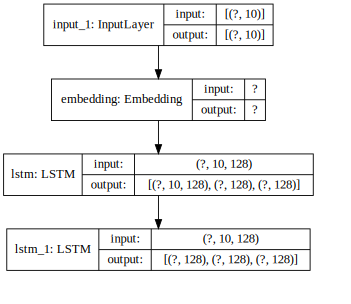

In [ ]:
# 인코더 모델
encoder_model = Model(X_input_E, [eh1, ec1, eh2, ec2])
print("========== 인코더 모델 구조 확인 ==========")
print(encoder_model.summary())
SVG(model_to_dot(encoder_model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [ ]:
# initial state 설정용 네트워크
ih1 = Input(batch_shape = (None, LSTM_HIDDEN))
ic1 = Input(batch_shape = (None, LSTM_HIDDEN))
ih2 = Input(batch_shape = (None, LSTM_HIDDEN))
ic2 = Input(batch_shape = (None, LSTM_HIDDEN))

In [ ]:
# 디코더 모델
dy1, dh1, dc1 = X_lstm1_D(X_embed_D, initial_state=[ih1, ic1]) # 초기 상태를 한 번씩 입력받기 위해
dy2, dh2, dc2 = X_lstm2_D(dy1, initial_state=[ih2, ic2]) # 초기 상태 

In [ ]:
# 출력 네트워크
y_output = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax')) # 시간 분배
y_output = y_output(dy2)

========== 디코더 모델 구조 확인 ==========
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             2650240     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________

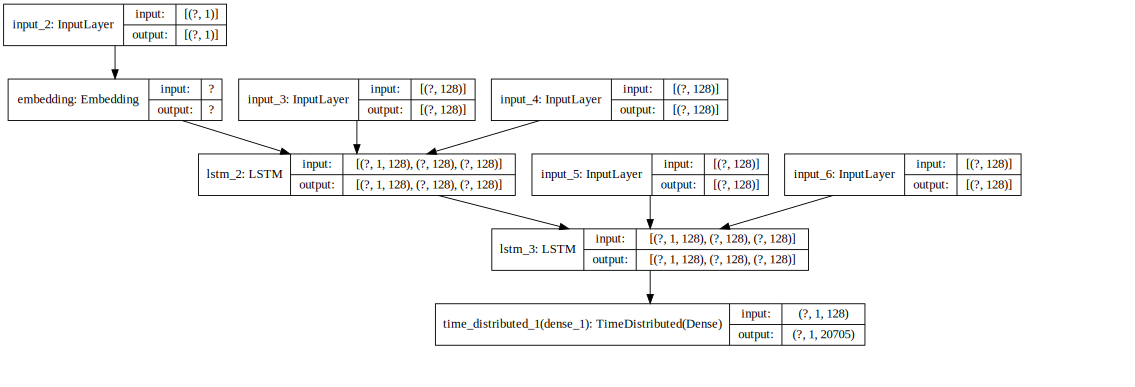

In [ ]:
# 디코더 모델
decoder_model = Model([X_input_D, ih1, ic1, ih2, ic2],
                      [y_output, dh1, dc1, dh2, dc2])
print("========== 디코더 모델 구조 확인 ==========")
print(decoder_model.summary())
SVG(model_to_dot(decoder_model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

### Question -> Answer

In [ ]:
# question 입력 받아 answer 생성
def genAnswer(question):
    question = question[np.newaxis, :]
    init_h1, init_c1, init_h2, init_c2 = encoder_model.predict(question)

    # 시작 단어는 <START>로 한다.
    word = np.array(word2idx['<START>']).reshape(1, 1)

    answer = []
    for i in range(MAX_LENGTH):
        dY, next_h1, next_c1, next_h2, next_c2 = \
            decoder_model.predict([word, init_h1, init_c1, init_h2, init_c2])
        
        # 디코더의 출력은 vocabulary에 대응되는 one-hot이다.
        # argmax로 해당 단어를 채택한다.
        next_word = np.argmax(dY[0, 0])
        
        # 예상 단어가 <END>이거나 <PADDING>이면 더 이상 예상할 게 없다.
        if next_word == word2idx['<END>'] or next_word == word2idx['<PADDING>']:
            break
        
        # 다음 예상 단어인 디코더의 출력을 answer에 추가한다.
        answer.append(idx2word[next_word])
        
        # 디코더의 다음 recurrent를 위해 입력 데이터와 hidden 값을
        # 준비한다. 입력은 word이고, hidden은 h와 c이다.
        word = np.array(next_word).reshape(1,1)
    
        init_h1 = next_h1
        init_c1 = next_c1
        init_h2 = next_h2
        init_c2 = next_c2
        
    return ' '.join(answer)

In [ ]:
# Chatting 모델 학습
def chatting(n=100):
    for i in range(n):
        question = input('Q : ')
        
        if  question == 'quit':
            break
        
        q_idx = []
        for x in question.split(' '):
            if x in word2idx:
                q_idx.append(word2idx[x])
            else:
                q_idx.append(word2idx['<UNKNOWN>'])   # out-of-vocabulary (OOV)
        
        # <PADDING>을 삽입한다.
        if len(q_idx) < MAX_LENGTH:
            q_idx.extend([word2idx['<PADDING>']] * (MAX_LENGTH - len(q_idx)))
        else:
            q_idx = q_idx[0:MAX_LENGTH]
        
        answer = genAnswer(np.array(q_idx))
        print('A :', answer)

In [ ]:
# 대화 시도
chatting()

Q : 오늘 배고픈데 뭐 먹을까?
A : 몰려오네 몰려오네 변해가네 짝사랑중인데 그리웠나봐요 변해가네 북치기박치기 날씨에 살았다는걸 연락왔는데진짜
Q : 비온다.
A : 끝이보였던 출발을 부족하니까 허전한 농담을 변해가네 썸에서 킁킁 킁킁 킁킁
Q : quit


In [ ]:
word2idx

{'<PADDING>': 0,
 '<START>': 1,
 '<END>': 2,
 '<UNKNOWN>': 3,
 '친구해도': 4,
 '바꾸는': 5,
 '조심해야해요': 6,
 '남자랑': 7,
 '만나': 8,
 '도와주면': 9,
 '아무말이나': 10,
 '차분히': 11,
 '3년': 12,
 '딸기가': 13,
 '돌아왔네': 14,
 '불러': 15,
 '쌩얼도': 16,
 '중간중간': 17,
 '하고싶다': 18,
 '다른게': 19,
 '필요하겠네요': 20,
 '놈인지': 21,
 '돌아다니는걸': 22,
 '유지해보세요': 23,
 '몇시쯤에': 24,
 '좋았길': 25,
 '생각하지마세요': 26,
 '물어보면서': 27,
 '기념일은': 28,
 '탈': 29,
 '지내는지': 30,
 '다녀야': 31,
 '허전할거라': 32,
 '짜증나게': 33,
 '상대에': 34,
 '줬어': 35,
 '공유해보세요': 36,
 '하루만에': 37,
 '주말': 38,
 '성별에': 39,
 '휴유증을': 40,
 '끝내니까': 41,
 '채워드릴게요': 42,
 '이게': 43,
 '못할거': 44,
 '방법도': 45,
 '매달렸다': 46,
 '기침이': 47,
 '이별1년': 48,
 '환승이별': 49,
 '내에': 50,
 '외모보다': 51,
 '카메라': 52,
 '태어나도': 53,
 '야경이': 54,
 '변화도': 55,
 '되는': 56,
 '미련은': 57,
 '끝냈어': 58,
 '서서히': 59,
 '전까지는': 60,
 '보러간': 61,
 '피곤한가봐요': 62,
 '남자야': 63,
 '퇴근길': 64,
 '충전해야겠다': 65,
 '연락해보는게': 66,
 '받아왔어': 67,
 '인턴': 68,
 '최소': 69,
 '드는걸로': 70,
 '척해': 71,
 '애기': 72,
 '아파서야': 73,
 '발견했는데': 74,
 '놀러': 75,
 '황당하지만': 76,
 '새출발할꺼야': 77,
 '되어버렸